In [ ]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
uris = [
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_1.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_3.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_4.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_5.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_6.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_7.jpg',
    '/content/drive/MyDrive/Colab Notebooks/car_detection/content/test_8.jpg'
]

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [ ]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [ ]:
print(len(detections_batch))
print(len(detections_batch[0]), detections_batch[0].shape)
print(len(detections_batch[1]), detections_batch[1].shape)

2
8 torch.Size([8, 4, 8732])
8 torch.Size([8, 81, 8732])


In [ ]:
results_per_input = utils.decode_results(detections_batch)
print(len(results_per_input), len(results_per_input[0]), 
      results_per_input[1][0].shape, results_per_input[1][1].shape, results_per_input[1][2].shape)


8 3 (20, 4) (20,) (20,)


In [ ]:
best_results_per_input = [utils.pick_best(results, 0.90) for results in results_per_input]
print(len(best_results_per_input), len(best_results_per_input[0]), 
      best_results_per_input[1][0].shape, best_results_per_input[1][1].shape, best_results_per_input[1][2].shape)

8 3 (0, 4) (0,) (0,)


In [ ]:
classes_to_labels = utils.get_coco_object_dictionary()

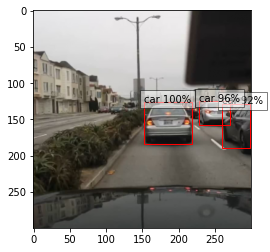

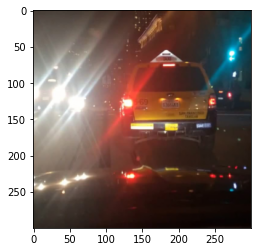

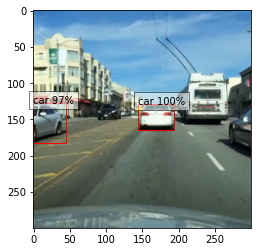

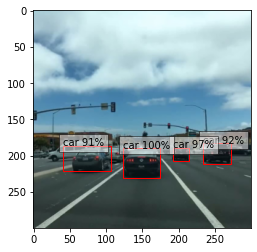

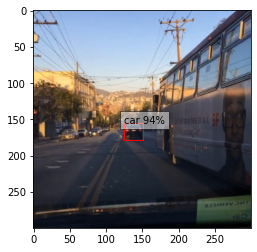

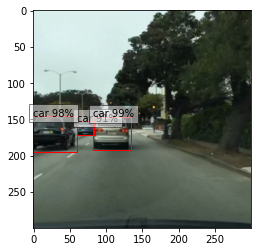

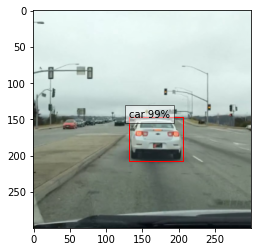

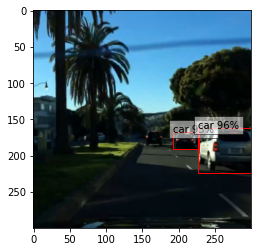

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()